In [602]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sklearn.metrics.pairwise 
import scipy
from math import pi, cos, sin
import math
from random import random
import sklearn
from sklearn import datasets

%matplotlib inline
plt.style.use(['ggplot'])

[[1.74439230e+00 1.33225746e+00 1.00000000e+00]
 [5.18838749e-01 2.87663211e+00 1.00000000e+00]
 [1.98390755e+00 2.17867828e+00 1.00000000e+00]
 [1.09864331e+00 1.00487715e+00 1.00000000e+00]
 [5.49396433e-01 1.10727584e+00 1.00000000e+00]
 [8.27521611e-01 1.01498670e+00 1.00000000e+00]
 [1.55691707e+00 2.83056811e+00 1.00000000e+00]
 [9.78312408e-01 1.00023520e+00 1.00000000e+00]
 [1.54714016e+00 1.16295900e+00 1.00000000e+00]
 [1.87441997e+00 2.48516979e+00 1.00000000e+00]
 [1.87090951e+00 1.50855659e+00 1.00000000e+00]
 [1.62994367e+00 1.22335918e+00 1.00000000e+00]
 [1.65269431e+00 2.75762137e+00 1.00000000e+00]
 [1.04219058e-01 2.44449579e+00 1.00000000e+00]
 [1.09234801e+00 2.99572679e+00 1.00000000e+00]
 [1.75893087e+00 1.34882880e+00 1.00000000e+00]
 [7.64052593e-01 1.02823417e+00 1.00000000e+00]
 [1.73628224e+00 1.32332544e+00 1.00000000e+00]
 [5.91374627e-04 2.03438604e+00 1.00000000e+00]
 [7.93534550e-01 1.02154611e+00 1.00000000e+00]
 [1.36318161e+00 1.06828163e+00 1.000000

/Users/Minae/anaconda3/envs/reward_adaptation/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


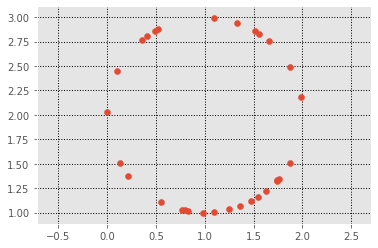

In [103]:
N = 30
#X = np.random.randint(1, 51, (N, 2)) # (2 X N)
#X = np.random.randn(N, 2)

def point(h, k, r):
    theta = random() * 2 * pi
    return [h + cos(theta) * r, k + sin(theta) * r, 1]


X = np.array([point(1,2,1) for _ in range(N)])
print(X)

plt.scatter(*zip(*np.delete(X, 2, 1)))
plt.grid(color='k', linestyle=':', linewidth=1)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [391]:
def unit_vector(data, axis=None, out=None):
    """Return ndarray normalized by length, i.e. Euclidean norm, along axis.
    """
    if out is None:
        data = np.array(data, dtype=np.float64, copy=True)
        if data.ndim == 1:
            data /= math.sqrt(np.dot(data, data))
            return data
    else:
        if out is not data:
            out[:] = np.array(data, copy=False)
        data = out
    length = np.atleast_1d(np.sum(data*data, axis))
    np.sqrt(length, length)
    if axis is not None:
        length = np.expand_dims(length, axis)
    data /= length
    if out is None:
        return data
    return None

def translation_matrix(direction):
    M = np.eye(3)
    M[:2, 2] = direction[:2]
    return M

def reflection_matrix(point, normal):
    normal = unit_vector(normal[:2])
    M = np.identity(3)
    M[:2, :2] -= 2.0 * np.outer(normal, normal)
    M[:2, 2] = (2.0 * np.dot(point[:2], normal)) * normal
    return M


# Reflections = {
#     'x': np.array([[1.0, 0.0, 0.0], 
#                    [0.0, -1.0, 0.0],
#                   [0.0, 0.0, 1.0]]),  # reflection on x ais
    
#     'y': np.array([[-1.0, 0.0, 0.0], 
#                         [0.0, 1.0, 0.0], 
#                   [0.0, 0.0, 1.0]]),  # reflection on y axis
    
#     'y=x': np.array([[0.0, 1.0, 0.0], 
#                         [1.0, 0.0, 0.0],
#                     [0.0, 0.0, 1.0]]),  # reflection on y=x
    
#     'y=-x': np.array([[0.0, -1.0, 0.0], 
#                         [-1.0, 0.0, 0.0],
#                      [0.0, 0.0, 1.0]]),  # reflection on y=-x
    
#     'origin': np.array([[-1.0, 0.0, 0.0], 
#                          [0.0, -1.0, 0.0],
#                        [0.0, 0.0, 1.0]]), # reflection on origin 

# }
translation_matrix([1,0])

array([[1., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [507]:
def cal_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    #predictions = X.dot(theta)
    predictions = theta @ X.T
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations+1)
    theta_history = np.zeros((iterations+1,3,3))
    grad_history = np.zeros((iterations+1,3,3))
    theta_history[0,:] = theta
    prediction = theta @ X.T
    grad_history[0, :] = -(1/m)*learning_rate*((prediction - y)@X)
    cost_history[0]  = 0.0
    for it in range(iterations):
        
        #prediction = np.dot(X,theta)
        prediction = theta @ X.T
        
        #theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
        #theta = theta -(1/m)*learning_rate*(X.T.dot((prediction - y)))
        theta = theta -(1/m)*learning_rate*((prediction - y)@X)
        theta_history[it+1,:] = theta
        grad_history[it+1, :] = -(1/m)*((prediction - y)@X)
        cost_history[it+1]  = cal_cost(theta,X,y)
        
    return theta, cost_history, theta_history, grad_history

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axs[0].annotate('{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height-5),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            fontsize=18,
            color="black",
            ha='center', va='bottom')
        

# Comparing gradient steps (Reflection vs Translation)


Reflection
init distance:  3.3530060781444253
perturbation:  1.732050807568877
grad steps:  491

Translation
init distance:  3.266513348564582
perturbation:  2.6457513110645907
grad steps:  589


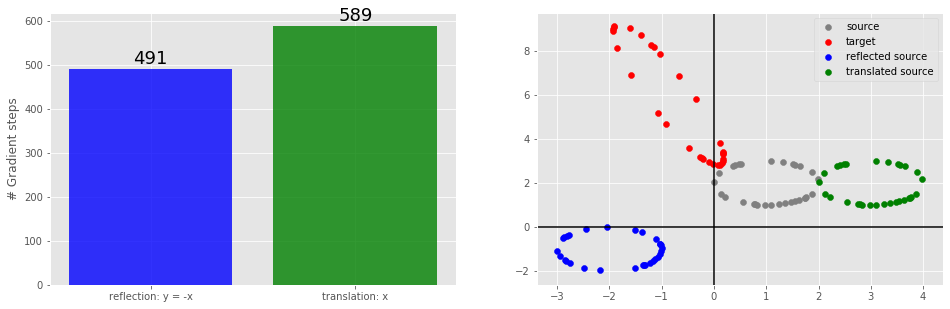

In [694]:
lr = 0.01
n_steps = 800
tolerance  = 0.001

#source = sklearn.datasets.make_spd_matrix(3)
source = np.eye(3)

# target policy
#Mt = np.random.rand(3,3)
Mt = sklearn.datasets.make_spd_matrix(3)
ut = Mt @ X.T

# reflected matrix
print("\nReflection")
R = reflection_matrix([0,0], [1, 1])
#R = reflection_matrix([0,0], [1, 0])

Mr = R@source
ur = Mr @ X.T
thetar, cost_history_ref, theta_history_ref, grad_history_ref = gradient_descent(X, ut, Mr, lr, n_steps)
assert (thetar == theta_history_ref[-1, :, :]).all()
print("init distance: ", np.linalg.norm(Mr-Mt))
print("perturbation: ", np.linalg.norm(Mr))
ref_steps = np.where(cost_history_ref[1:] <= tolerance)[0][0]
print("grad steps: ", ref_steps)

# translated matrix
print("\nTranslation")
T = translation_matrix([2,0])
Mtr = T@source
utr = Mtr @ X.T
thetatr, cost_history_trans, theta_history_trans, grad_history_trans = gradient_descent(X, ut, Mtr, lr, n_steps)
assert (thetatr == theta_history_trans[-1, :, :]).all()

print("init distance: ", np.linalg.norm(Mtr-Mt))
print("perturbation: ", np.linalg.norm(Mtr))

trans_steps = np.where(cost_history_trans[1:] <= tolerance)[0][0]
print("grad steps: ", trans_steps)

n_gradient_steps = [ref_steps, trans_steps]

# PLOT FIGURE
fig,axs = plt.subplots(1,2,figsize=(16,5))
x = [i for i in range(len(n_gradient_steps))]
axs[0].set_ylabel('# Gradient steps')
axs[0].set_xticks(x)
axs[0].set_xticklabels(["reflection: {}".format(ref_name), "translation: {}".format(trans_name)])

bar = axs[0].bar(x, n_gradient_steps, color=['b', 'g'], alpha=0.8)
autolabel(bar)

axs[1].scatter(*zip(*np.delete(X@source, 2, 1)), c='grey', label='source')
axs[1].scatter(*zip(*np.delete(ut.T, 2, 1)), c='red', label='target')
axs[1].scatter(*zip(*np.delete(ur.T, 2, 1)), c='blue', label='reflected source')
axs[1].scatter(*zip(*np.delete(utr.T, 2, 1)), c='green', label='translated source')
axs[1].axhline(y=0, color='k')
axs[1].axvline(x=0, color='k')
axs[1].legend()

Text(0.5, 1.0, 'Translation')

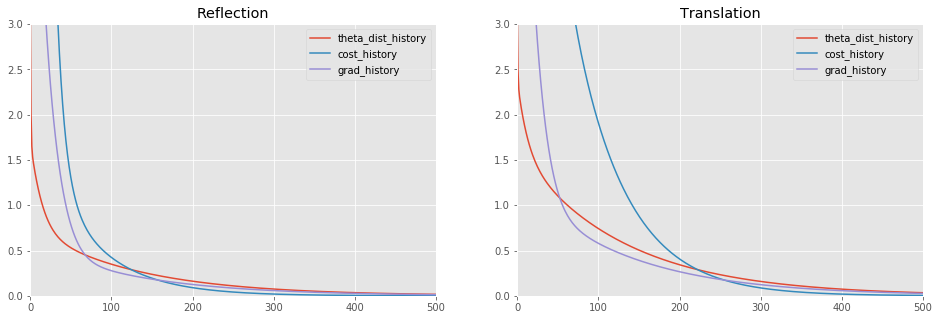

In [695]:
fig,axs = plt.subplots(1,2,figsize=(16,5))
x = range(len(theta_history_ref))
y = [np.linalg.norm(theta_history_ref[i,:,:] - Mt) for i in x]
ygrad = [np.linalg.norm(grad_history_ref[i,:,:]) for i in x]
axs[0].plot(x,y, label="theta_dist_history")
axs[0].plot(x,cost_history_ref, label="cost_history")
axs[0].plot(x,ygrad, label="grad_history")
axs[0].legend()
axs[0].set_ylim(0, 3)
axs[0].set_xlim(0, 500)

axs[0].set_title("Reflection")

x = range(len(theta_history_trans))
y = [np.linalg.norm(theta_history_trans[i,:,:] - Mt) for i in x]
ygrad = [np.linalg.norm(grad_history_trans[i,:,:]) for i in x]
axs[1].plot(x,y, label="theta_dist_history")
axs[1].plot(x,cost_history_trans, label="cost_history")
axs[1].plot(x,ygrad, label="grad_history")
axs[1].legend()
axs[1].set_ylim(0, 3)
axs[1].set_xlim(0, 500)

axs[1].set_title("Translation")

# Correlation analysis

## Translating by 2 units

[[1.        0.0462643]
 [0.0462643 1.       ]]
[[1.         0.59641837]
 [0.59641837 1.        ]]


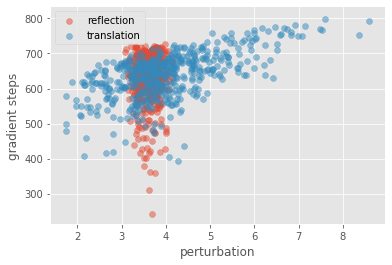

In [666]:
# Plot correlation between perturbation (norm) and gradient steps 
correlation_ref = []
correlation_trans = []
#source = np.eye(3)
for _ in range(500):
    rand1 = np.random.randint(0, 99999)
    source = sklearn.datasets.make_spd_matrix(3, rand1)
    
    rand2 = np.random.randint(0, 99999)
    Mt = sklearn.datasets.make_spd_matrix(3, rand2)
    ut = Mt @ X.T

    # reflected matrix
    #print("\nReflection")
    R = reflection_matrix([0,0], [1, 1])
    #R = reflection_matrix([0,0], [1, 0])

    Mr = R@source
    ur = Mr @ X.T
    thetar, cost_history_ref, theta_history_ref, grad_history_ref = gradient_descent(X, ut, Mr, lr, n_steps)
    assert (thetar == theta_history_ref[-1, :, :]).all()
    #print("init distance: ", np.linalg.norm(Mr-Mt))
    #print("perturbation: ", np.linalg.norm(Mr))
    ref_steps = np.where(cost_history_ref[1:] <= tolerance)[0][0]
    #print("grad steps: ", ref_steps)
    correlation_ref.append([np.linalg.norm(Mr), ref_steps])
    
    # translated matrix
    #print("\nTranslation")
    T = translation_matrix([2,0])
    Mtr = T@source
    utr = Mtr @ X.T
    thetatr, cost_history_trans, theta_history_trans, grad_history_trans = gradient_descent(X, ut, Mtr, lr, n_steps)
    assert (thetatr == theta_history_trans[-1, :, :]).all()

    #print("init distance: ", np.linalg.norm(Mtr-Mt))
    #print("perturbation: ", np.linalg.norm(Mtr))

    trans_steps = np.where(cost_history_trans[1:] <= tolerance)[0][0]
    #print("grad steps: ", trans_steps)
    correlation_trans.append([np.linalg.norm(Mtr), trans_steps])

    #n_gradient_steps = [ref_steps, trans_steps]
    
plt.scatter(*zip(*correlation_ref), label="reflection", alpha=0.5)
plt.scatter(*zip(*correlation_trans), label="translation", alpha=0.5)
plt.ylabel("gradient steps")
plt.xlabel("perturbation")
plt.legend()
print(np.corrcoef(*zip(*correlation_ref)))
print(np.corrcoef(*zip(*correlation_trans)))

## Translating by 1 unit 

[[ 1.         -0.04693861]
 [-0.04693861  1.        ]]
[[1.         0.29710557]
 [0.29710557 1.        ]]


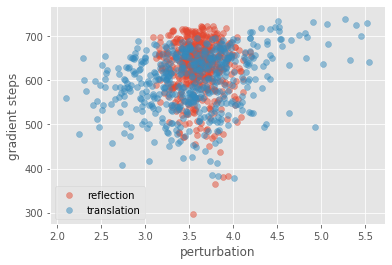

In [667]:
# Plot correlation between perturbation (norm) and gradient steps 
correlation_ref = []
correlation_trans = []
#source = np.eye(3)
for _ in range(500):
    rand1 = np.random.randint(0, 99999)
    source = sklearn.datasets.make_spd_matrix(3, rand1)
    
    rand2 = np.random.randint(0, 99999)
    Mt = sklearn.datasets.make_spd_matrix(3, rand2)
    ut = Mt @ X.T

    # reflected matrix
    #print("\nReflection")
    R = reflection_matrix([0,0], [1, 1])
    #R = reflection_matrix([0,0], [1, 0])

    Mr = R@source
    ur = Mr @ X.T
    thetar, cost_history_ref, theta_history_ref, grad_history_ref = gradient_descent(X, ut, Mr, lr, n_steps)
    assert (thetar == theta_history_ref[-1, :, :]).all()
    #print("init distance: ", np.linalg.norm(Mr-Mt))
    #print("perturbation: ", np.linalg.norm(Mr))
    ref_steps = np.where(cost_history_ref[1:] <= tolerance)[0][0]
    #print("grad steps: ", ref_steps)
    correlation_ref.append([np.linalg.norm(Mr), ref_steps])
    
    # translated matrix
    #print("\nTranslation")
    T = translation_matrix([1,0])
    Mtr = T@source
    utr = Mtr @ X.T
    thetatr, cost_history_trans, theta_history_trans, grad_history_trans = gradient_descent(X, ut, Mtr, lr, n_steps)
    assert (thetatr == theta_history_trans[-1, :, :]).all()

    #print("init distance: ", np.linalg.norm(Mtr-Mt))
    #print("perturbation: ", np.linalg.norm(Mtr))

    trans_steps = np.where(cost_history_trans[1:] <= tolerance)[0][0]
    #print("grad steps: ", trans_steps)
    correlation_trans.append([np.linalg.norm(Mtr), trans_steps])

    #n_gradient_steps = [ref_steps, trans_steps]
    
plt.scatter(*zip(*correlation_ref), label="reflection", alpha=0.5)
plt.scatter(*zip(*correlation_trans), label="translation", alpha=0.5)
plt.ylabel("gradient steps")
plt.xlabel("perturbation")
plt.legend()
print(np.corrcoef(*zip(*correlation_ref)))
print(np.corrcoef(*zip(*correlation_trans)))

## Translating by 0.3 units

[[1.         0.02403433]
 [0.02403433 1.        ]]
[[1.         0.06033996]
 [0.06033996 1.        ]]


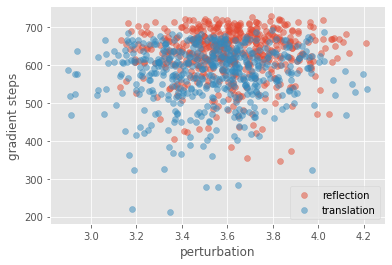

In [672]:
# Plot correlation between perturbation (norm) and gradient steps 
correlation_ref = []
correlation_trans = []
#source = np.eye(3)
for _ in range(500):
    rand1 = np.random.randint(0, 99999)
    source = sklearn.datasets.make_spd_matrix(3, rand1)
    
    rand2 = np.random.randint(0, 99999)
    Mt = sklearn.datasets.make_spd_matrix(3, rand2)
    ut = Mt @ X.T

    # reflected matrix
    #print("\nReflection")
    R = reflection_matrix([0,0], [1, 1])
    #R = reflection_matrix([0,0], [1, 0])

    Mr = R@source
    ur = Mr @ X.T
    thetar, cost_history_ref, theta_history_ref, grad_history_ref = gradient_descent(X, ut, Mr, lr, n_steps)
    assert (thetar == theta_history_ref[-1, :, :]).all()
    #print("init distance: ", np.linalg.norm(Mr-Mt))
    #print("perturbation: ", np.linalg.norm(Mr))
    ref_steps = np.where(cost_history_ref[1:] <= tolerance)[0][0]
    #print("grad steps: ", ref_steps)
    correlation_ref.append([np.linalg.norm(Mr), ref_steps])
    
    # translated matrix
    #print("\nTranslation")
    T = translation_matrix([.3,0])
    Mtr = T@source
    utr = Mtr @ X.T
    thetatr, cost_history_trans, theta_history_trans, grad_history_trans = gradient_descent(X, ut, Mtr, lr, n_steps)
    assert (thetatr == theta_history_trans[-1, :, :]).all()

    #print("init distance: ", np.linalg.norm(Mtr-Mt))
    #print("perturbation: ", np.linalg.norm(Mtr))

    trans_steps = np.where(cost_history_trans[1:] <= tolerance)[0][0]
    #print("grad steps: ", trans_steps)
    correlation_trans.append([np.linalg.norm(Mtr), trans_steps])

    #n_gradient_steps = [ref_steps, trans_steps]
    
plt.scatter(*zip(*correlation_ref), label="reflection", alpha=0.5)
plt.scatter(*zip(*correlation_trans), label="translation", alpha=0.5)
plt.ylabel("gradient steps")
plt.xlabel("perturbation")
plt.legend()
print(np.corrcoef(*zip(*correlation_ref)))
print(np.corrcoef(*zip(*correlation_trans)))

In [686]:
correlation_ref = np.array(correlation_ref)
print("mean # steps, reflection: ", np.mean(correlation_ref[:,1]))

correlation_trans = np.array(correlation_trans)
print("mean # steps, translation: ", np.mean(correlation_trans[:,1]))

mean # steps, reflection:  629.284
mean # steps, translation:  574.154


## Translating by 0.01 units

[[1.         0.03996943]
 [0.03996943 1.        ]]
[[ 1.         -0.03785938]
 [-0.03785938  1.        ]]


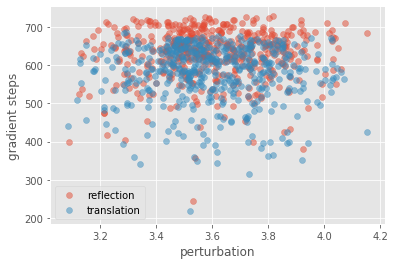

In [698]:
# Plot correlation between perturbation (norm) and gradient steps 
correlation_ref = []
correlation_trans = []
#source = np.eye(3)
for _ in range(500):
    rand1 = np.random.randint(0, 99999)
    source = sklearn.datasets.make_spd_matrix(3, rand1)
    
    rand2 = np.random.randint(0, 99999)
    Mt = sklearn.datasets.make_spd_matrix(3, rand2)
    ut = Mt @ X.T

    # reflected matrix
    #print("\nReflection")
    R = reflection_matrix([0,0], [1, 1])
    #R = reflection_matrix([0,0], [1, 0])

    Mr = R@source
    ur = Mr @ X.T
    thetar, cost_history_ref, theta_history_ref, grad_history_ref = gradient_descent(X, ut, Mr, lr, n_steps)
    assert (thetar == theta_history_ref[-1, :, :]).all()
    #print("init distance: ", np.linalg.norm(Mr-Mt))
    #print("perturbation: ", np.linalg.norm(Mr))
    ref_steps = np.where(cost_history_ref[1:] <= tolerance)[0][0]
    #print("grad steps: ", ref_steps)
    correlation_ref.append([np.linalg.norm(Mr), ref_steps])
    
    # translated matrix
    #print("\nTranslation")
    T = translation_matrix([.01,0])
    Mtr = T@source
    utr = Mtr @ X.T
    thetatr, cost_history_trans, theta_history_trans, grad_history_trans = gradient_descent(X, ut, Mtr, lr, n_steps)
    assert (thetatr == theta_history_trans[-1, :, :]).all()

    #print("init distance: ", np.linalg.norm(Mtr-Mt))
    #print("perturbation: ", np.linalg.norm(Mtr))

    trans_steps = np.where(cost_history_trans[1:] <= tolerance)[0][0]
    #print("grad steps: ", trans_steps)
    correlation_trans.append([np.linalg.norm(Mtr), trans_steps])

    #n_gradient_steps = [ref_steps, trans_steps]
    
plt.scatter(*zip(*correlation_ref), label="reflection", alpha=0.5)
plt.scatter(*zip(*correlation_trans), label="translation", alpha=0.5)
plt.ylabel("gradient steps")
plt.xlabel("perturbation")
plt.legend()
print(np.corrcoef(*zip(*correlation_ref)))
print(np.corrcoef(*zip(*correlation_trans)))

In [699]:
correlation_ref = np.array(correlation_ref)
print("mean # steps, reflection: ", np.mean(correlation_ref[:,1]))

correlation_trans = np.array(correlation_trans)
print("mean # steps, translation: ", np.mean(correlation_trans[:,1]))

mean # steps, reflection:  629.496
mean # steps, translation:  577.392
